# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 3 - Mapas de Kohonen

Estudante: Felipe da Costa Pereira

In [ ]:
!git clone https://github.com/mdrs-thiago/minisom

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

from minisom.minisom import MiniSom

In [ ]:
filePath = os.getcwd()+'\\datasets'+'\\class_thyroid.csv'
dataset = pd.read_csv(filePath)

In [ ]:
X = dataset.values[:,:-1]
X.shape

In [ ]:
feature_names = dataset.columns.values[:-1]
feature_names

## Parte 1 - Testando configurações

Nesta primeira etapa, iremos investigar como a configuração do mapa pode mudar de acordo com a escolha de parâmetros. 

##### 1. Escolha os parâmetros para o primeiro teste usando SOM. Para cada parâmetro, justifique sua escolha. Avalie o resultado.

In [133]:
#Dimensão do vetor de entrada
input_len = X.shape[1]
X = minmax_scale(X)

topology = 'hexagonal'

# map dimensions
m = 13
n = 13

###############################
###############################
# 1a fase - Ordering Phase
###############################
###############################
ordering_lr = 0.9
ordering_time = 4000

# decay function 
def decay_fcn_ordering(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    new_lr = lr/(1 + 2*actual_t/max_t)
    return new_lr

###############################
###############################
# 2a fase - Fine Adjustment Phase 
#   Ideally alpha < 0.02 and constant
###############################
###############################
finetuning_lr = 0.006 # constant
finetuning_time = 650 * m * n
# finetuning_time = 5000


# decay function 
def decay_fcn_finetuning(lr,actual_t,max_t):
    return lr

Model builder

In [134]:
som = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering)
som.pca_weights_init(X)

# name to be retrieved after
somname_file = f'som_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn'

Ordering Phase Training

In [135]:
som.train_random(X, ordering_time, verbose=True)

 [ 4000 / 4000 ] 100% - 0:00:00 left 
 quantization error: 0.02784162874837221


0.28867513459481287


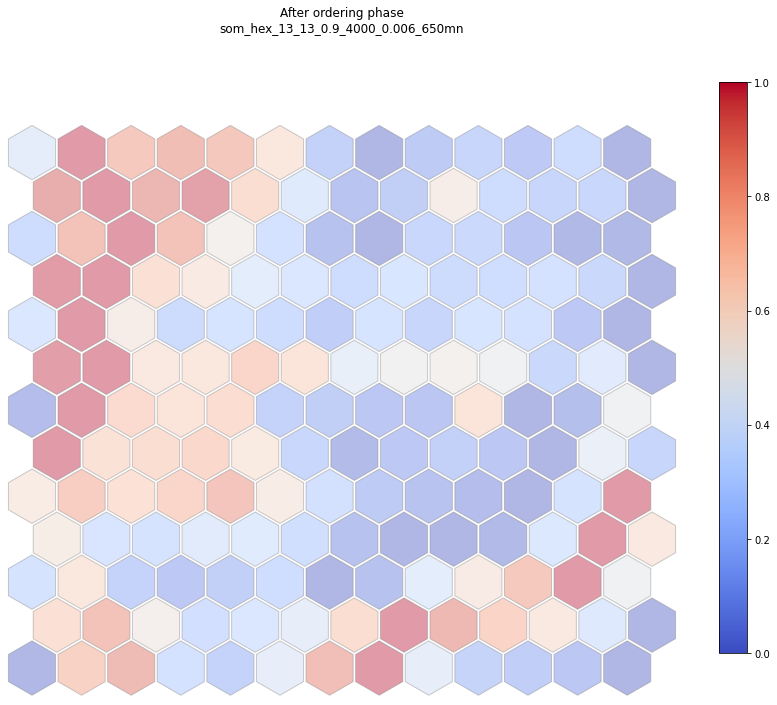

In [136]:
quant_err = som._quantization_error
topo_err = som._topographic_error
som.plot_umatrix(names=[f'After ordering phase\n{somname_file}'])

Finetuning phase Training

In [137]:
som._learning_rate = finetuning_lr
som._decay_function = decay_fcn_finetuning
som.train_random(X, finetuning_time, verbose=True)

 [  54713 / 109850 ]  50% - 0:07:38 left 

Cumulating quantization and topographic errors in both phases

In [ ]:
quant_err += som._quantization_error
topo_err += som._topographic_error

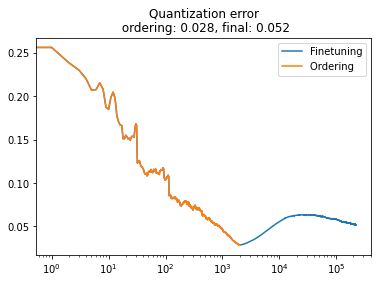

In [ ]:
plt.plot(quant_err)
plt.plot(quant_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Quantization error\n ordering: {np.min(quant_err[:ordering_time]):.3f}, final: {quant_err[-1]:.3f}')
plt.xscale('log')
plt.savefig(somname_file+'_qerr.png')
pass;

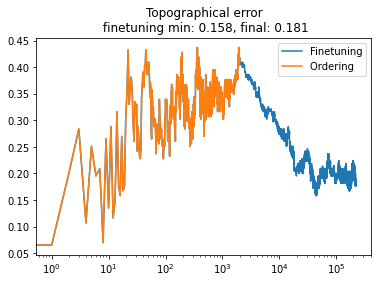

In [ ]:
plt.plot(topo_err)
plt.plot(topo_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Topographical error\n finetuning min: {np.min(topo_err[ordering_time:]):.3f}, final: {topo_err[-1]:.3f}')
plt.xscale('log')
plt.savefig(somname_file+'_terr.png')
pass;

0.28867513459481287


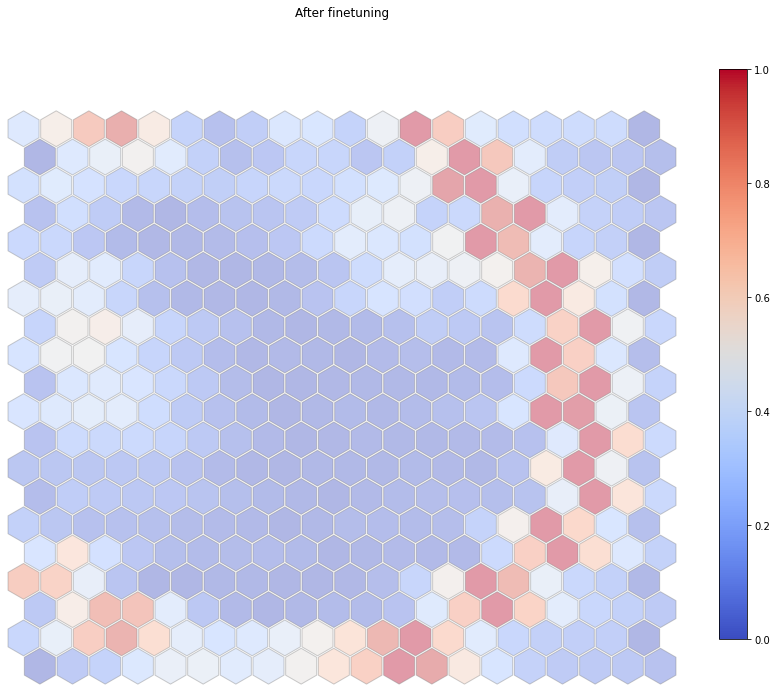

In [ ]:
som.plot_umatrix(names=[f'After finetunning\n{somname_file}'])

In [ ]:
plt.savefig('d')

<Figure size 432x288 with 0 Axes>

Saving som to disk

In [ ]:
import pickle
  
def save_som(som, filename):
    '''
    function to save a som to disk
    
    ## INPUTS:
    som: som object
    filename - file name
    '''
    som_file = open(filename, 'ab')
    pickle.dump(som, som_file)                     
    som_file.close()
  
def load_som(filename):
    '''
    function to read a som saved to disk
    
    ## INPUTS:
    filename - file name
    ## RETURNS:
    som instance
    '''
    # for reading also binary mode is important
    som_file = open(filename, 'rb')     
    som = pickle.load(som_file)
    som_file.close()
    return som

In [ ]:

save_som(som, somname_file)
somname_file

'som_20_20_0.99_2000_0.004_550mn'

In [ ]:
# som2 = load_som('som_16_16_0.99_1000_0.008_400mn')

##### 2. Modifique a topologia da rede. Teste diferentes valores e avalie o resultado.

In [ ]:
# sigma
# neighborhood_function

##### 3. Modifique a normalização dos dados de entrada e avalie o resultado obtido. Esta mudança tem algum efeito no mapa gerado?

##### 4. Modifique o processo de treinamento durante a fase de ordenação. Avalie o resultado gerado.

##### 5. Modifique o processo de treinamento durante a fase de ajuste fino. Avalie o resultado gerado.

##### 6. Modifique a função de decaimento da taxa de aprendizado. Esta mudança gera algum impacto no mapa gerado? Justifique

##### 7. Altere a função de vizinhança. Avalie o resultado.

## Parte 2 - Análise dos mapas

##### 1. Teste novas configurações para o modelo SOM para obter um melhor resultado. Justifique a escolha dos parâmetros do modelo selecionado.

##### 2. Utilizando a melhor configuração do item anterior, analise os diferentes mapas fornecidos e caracterize os grupos de pacientes obtidos.